### Задание 2

Необходимо построить модель, которая на основании данных, поступающих каждую минуту, определяет качество продукции, производимое на обжиговой машине.

Оценкой модели будет являться показатель MAE. 

In [170]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings('ignore')

Загрузим данные:

In [2]:
X_data = pd.read_csv("../../r_data/X_data.csv", sep=";", index_col= 0,  parse_dates=True) 
Y_submit = pd.read_csv("../../r_data/Y_submit.csv", header=None, sep=";", index_col= 0,  parse_dates=True) 
Y_train = pd.read_csv("../../r_data/Y_train.csv", header=None, sep=";", index_col= 0,  parse_dates=True) 

In [3]:
Y_train.describe()

1
count  29184.000000
mean     402.800747
std       46.273228
min      221.000000
25%      372.000000
50%      408.000000
75%      439.000000
max      505.000000

In [71]:
X_data.head()

T_data_1_1  T_data_1_2  T_data_1_3  T_data_2_1  \
2015-01-01 00:00:00         212         210         211         347   
2015-01-01 00:01:00         212         211         211         346   
2015-01-01 00:02:00         212         211         211         345   
2015-01-01 00:03:00         213         211         211         344   
2015-01-01 00:04:00         213         211         211         343   

                     T_data_2_2  T_data_2_3  T_data_3_1  T_data_3_2  \
2015-01-01 00:00:00         353         347         474         473   
2015-01-01 00:01:00         352         346         475         473   
2015-01-01 00:02:00         352         346         476         473   
2015-01-01 00:03:00         351         346         477         473   
2015-01-01 00:04:00         350         346         478         473   

                     T_data_3_3  T_data_4_1  T_data_4_2  T_data_4_3  \
2015-01-01 00:00:00         481         346         348         355   
2015-01-01 00:01:00         481         349         348         355   
2015-01-01 00:02:00         481         352         349         355   
2015-01-01 00:03:00         481         355         349         355   
2015-01-01 00:04:00         482         358         349         355   

                     T_data_5_1  T_data_5_2  T_data_5_3  H_data  AH_data  
2015-01-01 00:00:00         241         241         243  167.85     9.22  
2015-01-01 00:01:00         241         241         243  162.51     9.22  
2015-01-01 00:02:00         242         241         242  164.99     9.22  
2015-01-01 00:03:00         242         241         242  167.34     9.22  
2015-01-01 00:04:00         243         241         242  163.04     9.22

In [72]:
Y_train.head()

1
0                       
2015-01-04 00:05:00  392
2015-01-04 01:05:00  384
2015-01-04 02:05:00  393
2015-01-04 03:05:00  399
2015-01-04 04:05:00  400

Данные с датчиков снимаются каждую минуту, а качество продукции измеряется каждый час. 

Чтобы получить предсказания качества для начала просто возьмем среднее значение на каждом датчике в течение часа:

In [4]:
resampled = X_data.resample('60T', base=5).mean()
X_train = resampled[resampled.index.isin(Y_train.index)]
X_submit = resampled[resampled.index.isin(Y_submit.index)]

In [173]:
resampled.to_csv('X_resampled.csv')

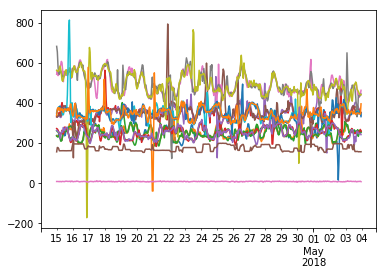

In [18]:
X_train['2018-4-15':].plot(legend = False);

Добавим в X_train также среднее по датчикам для каждой камеры:

In [171]:
a, b = 0, 3
for i in range (5):
    X_train['mean_'+str(i+1)] = X_train.iloc[:, a:b ].mean(axis=1)
    a += 3
    b += 3 

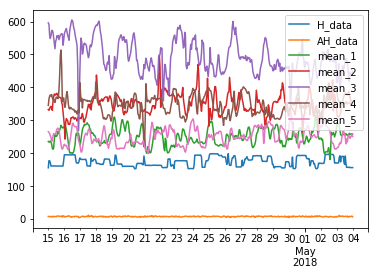

In [74]:
X_train.loc['2018-4-15':, 'H_data':].plot();

In [6]:
X_train_norm = (X_train - X_train.mean()) / (X_train.max() - X_train.min())

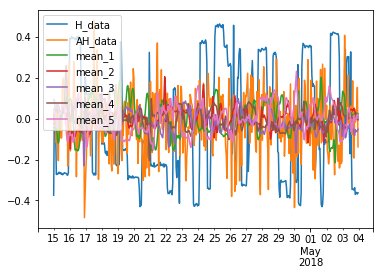

In [17]:
X_train_norm.loc['2018-4-15':, 'H_data':].plot()

Построив pair plot, чтобы увидеть взаимосвязь между переменными модели:

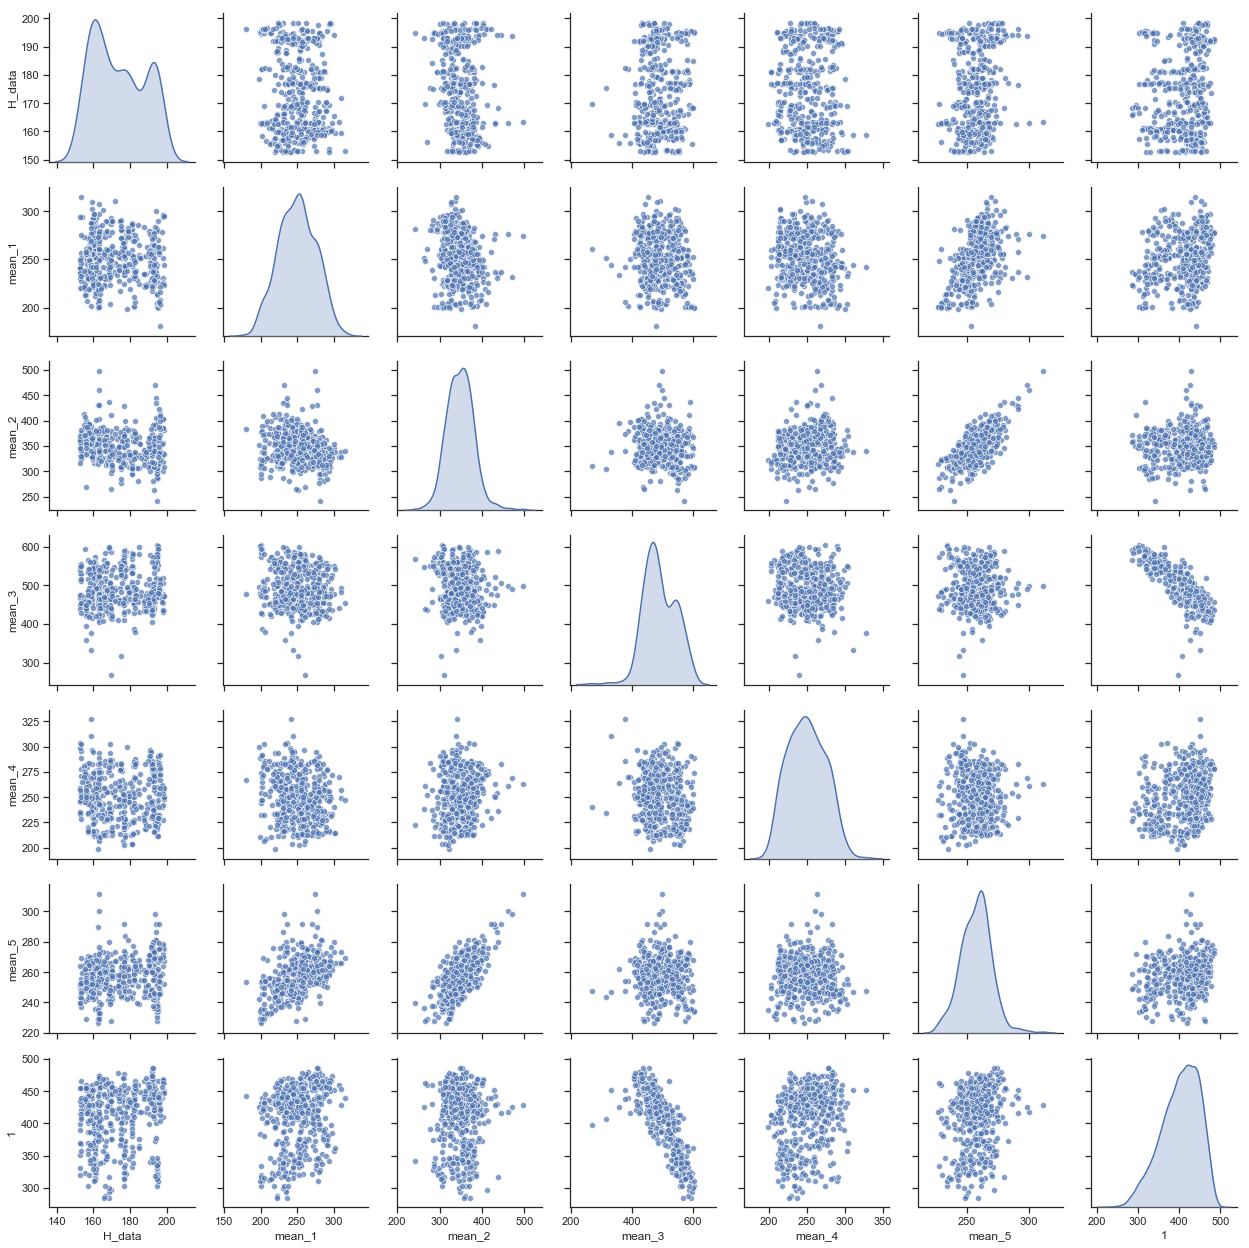

In [172]:
sns.set(style="ticks", color_codes=True);
sns.pairplot(pd.concat([X_train.loc['2018-4-15':, 'H_data':],Y_train], axis = 1), diag_kind = 'kde', plot_kws=dict(alpha = 0.7),
                   diag_kws=dict(shade=True));

Стоит отметить отрицательную корреляцию качества продукции и среднего по показаниям датчиков 3-ей камеры

Разделим имеющиеся данные на трейн и тест:

In [7]:
train_features, test_features, train_y, test_y = X_train[:-5808], X_train[-5808:], Y_train[:-5808], Y_train[-5808:] 

In [12]:
regr = RandomForestRegressor(max_depth=10, random_state=42, n_estimators=10, criterion = 'mae')

In [ ]:
regr.fit(train_features, train_y)

In [22]:
predictions = regr.predict(test_features)
predictions

array([469. , 481. , 481. , ..., 462. , 453. , 449.5])

In [23]:
test_plot = test_y.copy()

In [24]:
test_plot['rf_1'] = predictions

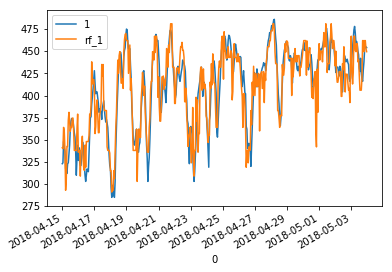

In [25]:
test_plot.loc['2018-4-15':, :].plot();

Сравним качество модели с моделью, предсказвающей для всех значений среднее по train_y за все время

In [98]:
mean_absolute_error(test_y,np.repeat(np.mean(train_y.values),5808))

38.17512027593463

In [118]:
mean_absolute_error(test_y,predictions)

14.018543388429752

Результат - улучшение прогноза в несколько раз.

Попробуем подобрать гиперпараметры для модели с помощью рандомизированного поиска:

In [53]:
from sklearn.model_selection import RandomizedSearchCV

max_depth = [int(x) for x in np.linspace(10, 50, num = 5)]
max_depth.append(None)

random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 50, stop = 250, num = 5)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': max_depth,
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [50, 100, 150, 200, 250]}


Поскольку выборка очень большая перебор на всех данных занимает слишком много времени, сделаем подбор по последним наблюдениям:

In [ ]:
rf = RandomForestRegressor(criterion = 'mae', random_state=38)
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 2, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(train_features[20000:], np.ravel(train_y[20000:]))

In [63]:
rf_random.best_params_

{'n_estimators': 250,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

In [64]:
best_random = rf_random.best_estimator_

In [65]:
best_random.fit(train_features,train_y)

/home/xenakas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=38, verbose=0, warm_start=False)

In [66]:
best_predictions = best_random.predict(test_features)
best_predictions

array([479.836, 480.658, 481.496, ..., 459.594, 455.53 , 446.6  ])

In [67]:
test_plot['rf_best'] = best_predictions

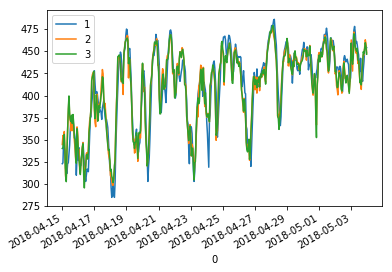

In [68]:
test_plot.loc['2018-4-15':, :].plot() 

С помощью подбора гиперпараметров удалось уменьшить mae:

In [118]:
mean_absolute_error(test_y,predictions)

14.018543388429752

In [69]:
mean_absolute_error(test_y,best_predictions)

13.087920798898072

Проверим, какие переменные внесли наибольшй вклад:

In [28]:
importances = list(regr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(X_train.columns.values
, importances)]

In [29]:
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair)) 

Variable: T_data_1_1           Importance: 0.02
Variable: T_data_1_2           Importance: 0.02
Variable: T_data_1_3           Importance: 0.02
Variable: T_data_2_1           Importance: 0.01
Variable: T_data_2_2           Importance: 0.01
Variable: T_data_2_3           Importance: 0.01
Variable: T_data_3_1           Importance: 0.02
Variable: T_data_3_2           Importance: 0.02
Variable: T_data_3_3           Importance: 0.03
Variable: T_data_4_1           Importance: 0.0
Variable: T_data_4_2           Importance: 0.0
Variable: T_data_4_3           Importance: 0.0
Variable: T_data_5_1           Importance: 0.02
Variable: T_data_5_2           Importance: 0.01
Variable: T_data_5_3           Importance: 0.01
Variable: H_data               Importance: 0.04
Variable: AH_data              Importance: 0.0
Variable: mean_1               Importance: 0.02
Variable: mean_2               Importance: 0.01
Variable: mean_3               Importance: 0.66
Variable: mean_4               Importance: 0

Очевидно, что часть признаков важнее других, впролне возможно, что при добавлении дополнительных признаков и избавлении от признаков с нулевой важностью, мы сможем улучшить качество прогоноза. 

Добавим число выбросов, произошедших за час:

In [41]:
def outliers_z_score(ys):
    threshold = 3
    mean_y = np.mean(ys)
    stdev_y = np.std(ys)
    z_scores = [(y - mean_y) / stdev_y for y in ys]
    z_scores = np.where(np.abs(z_scores) < threshold, 0, z_scores )
    z_scores = np.where(np.abs(z_scores) >= threshold, 1, z_scores )
    return z_scores 

In [51]:
x_out = X_data.iloc[:, :-2].apply(outliers_z_score, axis=0).sum(axis=1)

In [56]:
x_out = x_out.resample('60T', base=5).sum()

In [63]:
X_data_new = X_train.copy()

In [66]:
X_data_new = X_data_new.drop(['T_data_4_1', 'T_data_4_2', 'T_data_4_3'], axis=1)

In [67]:
X_data_new['out'] = x_out

In [70]:
names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

for i, x in enumerate(names):
    X_data_new[x] = (X_data_new.index.weekday == i).astype(int)


In [123]:
train_features, test_features, train_y, test_y = X_data_new[:-5808], X_data_new[-5808:], Y_train[:-5808], Y_train[-5808:] 

In [125]:
regr_new = RandomForestRegressor(max_depth=10, random_state=42, n_estimators=10, criterion = 'mae')

In [126]:
regr_new.fit(train_features, train_y)

/home/xenakas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mae', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [127]:
predictions_new = regr_new.predict(test_features)
predictions_new

array([475.9 , 478.2 , 479.6 , ..., 459.45, 454.2 , 448.65])

In [128]:
test_plot['rf_new'] = predictions_new

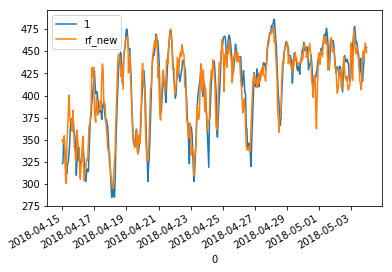

In [129]:
test_plot.loc['2018-4-15':, :].plot();

Сравним качество модели с первой моделью:

In [118]:
mean_absolute_error(test_y,predictions)

14.018543388429752

In [130]:
mean_absolute_error(test_y,predictions_new)

14.070377066115702

In [131]:
importances = list(regr_new.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_features.columns.values
, importances)]

In [132]:
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair)) 

Variable: T_data_1_1           Importance: 0.02
Variable: T_data_1_2           Importance: 0.02
Variable: T_data_1_3           Importance: 0.02
Variable: T_data_2_1           Importance: 0.01
Variable: T_data_2_2           Importance: 0.01
Variable: T_data_2_3           Importance: 0.01
Variable: T_data_3_1           Importance: 0.04
Variable: T_data_3_2           Importance: 0.03
Variable: T_data_3_3           Importance: 0.03
Variable: T_data_5_1           Importance: 0.02
Variable: T_data_5_2           Importance: 0.02
Variable: T_data_5_3           Importance: 0.02
Variable: H_data               Importance: 0.04
Variable: AH_data              Importance: 0.0
Variable: mean_1               Importance: 0.02
Variable: mean_2               Importance: 0.01
Variable: mean_3               Importance: 0.65
Variable: mean_4               Importance: 0.0
Variable: mean_5               Importance: 0.04
Variable: out                  Importance: 0.0
Variable: Monday               Importance: 

Ни одна из дополнительных переменных не повлияла на качество прогноза

В качестве модели  с помощью которой мы будем пргонозировать выбираем RandomForestRegressor с гиперпараметрами, подобранными с помощью RandomizedSearchCV и все показатели для первой модели, кроме показателей по отдельным датчикам 4 камеры и AH_data, так как для прогноза они имели нулевой вклад:

In [ ]:
X_train = X_train.drop(['T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'AH_data'], axis=1)

In [138]:
train_features, test_features, train_y, test_y = X_train[:-5808], X_train[-5808:], Y_train[:-5808], Y_train[-5808:] 

In [139]:
best_regr = RandomForestRegressor(max_depth=50, random_state=42, n_estimators=250, criterion = 'mae', min_samples_split = 5, min_samples_leaf = 1,  max_features = 'sqrt', bootstrap = False )

In [140]:
best_regr.fit(train_features, train_y)

/home/xenakas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=False, criterion='mae', max_depth=50,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=None,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [147]:
predictions_best = best_regr.predict(test_features)
predictions_best

array([480.212, 480.726, 481.856, ..., 460.496, 456.292, 447.592])

In [148]:
test_plot['rf_best'] = predictions_best

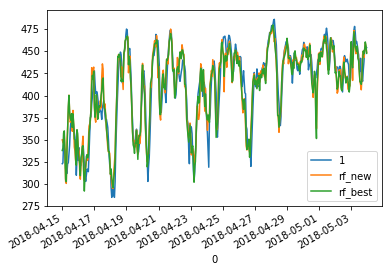

In [149]:
test_plot.loc['2018-4-15':, :].plot();

In [153]:
importances = list(best_regr.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(train_features.columns.values
, importances)]

In [154]:
for pair in feature_importances:
    print('Variable: {:20} Importance: {}'.format(*pair)) 

Variable: T_data_1_1           Importance: 0.02
Variable: T_data_1_2           Importance: 0.02
Variable: T_data_1_3           Importance: 0.02
Variable: T_data_2_1           Importance: 0.02
Variable: T_data_2_2           Importance: 0.02
Variable: T_data_2_3           Importance: 0.02
Variable: T_data_3_1           Importance: 0.14
Variable: T_data_3_2           Importance: 0.15
Variable: T_data_3_3           Importance: 0.16
Variable: T_data_5_1           Importance: 0.03
Variable: T_data_5_2           Importance: 0.03
Variable: T_data_5_3           Importance: 0.03
Variable: H_data               Importance: 0.04
Variable: mean_1               Importance: 0.03
Variable: mean_2               Importance: 0.02
Variable: mean_3               Importance: 0.2
Variable: mean_4               Importance: 0.02
Variable: mean_5               Importance: 0.03


Сравним качество модели с первой моделью:

In [144]:
mean_absolute_error(test_y,predictions_new)

14.070377066115702

In [150]:
mean_absolute_error(test_y,predictions_best)

12.849432851239671

Для этой модели mae минимальный. Выбираем ее для предсказания Y_submit:

In [161]:
a, b = 0, 3
for i in range (5):
    X_submit['mean_'+str(i+1)] = X_submit.iloc[:, a:b ].mean(axis=1)
    a += 3
    b += 3 

In [157]:
X_submit = X_submit.drop(['T_data_4_1', 'T_data_4_2', 'T_data_4_3', 'AH_data'], axis=1)

In [163]:
predictions_submit = best_regr.predict(X_submit)
predictions_submit

array([434.246, 428.666, 410.59 , ..., 445.764, 444.784, 442.906])

In [166]:
Y_submit[1] = predictions_submit

In [169]:
Y_submit.to_csv('Y_submit.csv', header=0)